In [ ]:
!pip install sumeval
!pip install py7zr

# Decription 
### Fine-Tune a T5 model on the samsum dataset using Pytorch and HugingFace.

In [2]:
import gc
import random
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sumeval.metrics.rouge import RougeCalculator

import torch
from transformers import T5Tokenizer
import transformers
from transformers import T5ForConditionalGeneration
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import os
from datasets import load_dataset, Dataset
from transformers import get_scheduler
from torch.optim import AdamW
from torch.utils.data import DataLoader

print('Pytorch version: %s'  % torch.__version__)

Pytorch version: 1.11.0


In [3]:
warnings.simplefilter('ignore')
pd.set_option('display.max_colwidth', 100)

## Reading Data

In [4]:
dataset = load_dataset("samsum")

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/3f7dba43be72ab10ca66a2e0f8547b3590e96c2bd9f2cbb1f6bb1ec1f1488ba6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
def add_prefix(train, valid, test):
    # adding summarize in front of data
    train_df = pd.DataFrame(train)
    train_df["dialogue"] = "summarize: " + train_df["dialogue"]
    train = Dataset.from_pandas(train_df)

    valid_df = pd.DataFrame(valid)
    valid_df["dialogue"] = "summarize: " + valid_df["dialogue"]
    valid = Dataset.from_pandas(valid_df)

    test_df = pd.DataFrame(test)
    test_df["dialogue"] = "summarize: " + test_df["dialogue"]
    test = Dataset.from_pandas(test_df)

    return train, valid, test

In [6]:
train = dataset["train"]
valid = dataset["validation"]
test = dataset["test"]

train = train.remove_columns(["id"])
valid = valid.remove_columns(["id"])
test = test.remove_columns(["id"])

train, valid, test = add_prefix(train, valid, test)

print(len(train), len(valid), len(test))
print("dataset has features: ", train)
print("sample input and output is")
print(train[0]["dialogue"])
print(train[0]["summary"])


14732 818 819
dataset has features:  Dataset({
    features: ['dialogue', 'summary'],
    num_rows: 14732
})
sample input and output is
summarize: Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)
Amanda baked cookies and will bring Jerry some tomorrow.


## Data Analysis

In [7]:
# analyze input and summary lengths
dialogue_lengths = [len(text.split()) for text in train["dialogue"]]
summary_lengths = [len(text.split()) for text in train["summary"]]
print("average length of dialogue is", sum(dialogue_lengths)/len(dialogue_lengths))
print("average length of summary is", sum(summary_lengths)/len(summary_lengths))

average length of dialogue is 94.7863833831116
average length of summary is 20.3174721694271


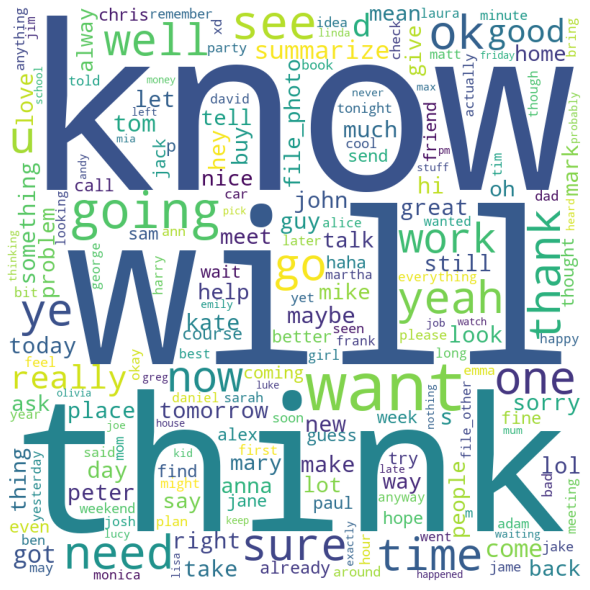

In [8]:
comment_words = ''
stopwords = set(STOPWORDS)
 
for text in train["dialogue"]:
    tokens = text.split()
    
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "

for text in train["summary"]:
    tokens = text.split()
    
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## Building custom Data class

In [9]:
# this class object will be passed to the dataloader
from torch.utils.data import Dataset
class LoadData(Dataset):
    """
    Using this since dataloader expects map-style dataset objects
    
    """
    
    def __init__(
        self, dataset, tokenizer, source_length, target_length):
        """
        Initializes a Dataset class

        Args:
            dataset (Dataset object): Input Dataset
            tokenizer (Tokenizer object): Transformer tokenizer
            source_length (int): Max length of source text
            target_length (int): Max length of target text
        """
        
        self.tokenizer = tokenizer
        self.data = dataset
        self.source_length = source_length
        self.summary_length = target_length
        self.target_text = self.data["summary"]
        self.source_text = self.data["dialogue"]

    def __len__(self):
        return len(self.target_text)

    def __getitem__(self, index):
        """
        return input ids, attention masks and target ids
        
        """
        source_text = str(self.source_text[index])
        target_text = str(self.target_text[index])

        # cleaning data so as to ensure data is in string type
        source_text = " ".join(source_text.split())
        target_text = " ".join(target_text.split())

        source = self.tokenizer.__call__(
            [source_text],
            max_length=self.source_length,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        
        target = self.tokenizer.__call__(
            [target_text],
            max_length=self.summary_length,
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        source_ids = source["input_ids"].squeeze()
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        target_mask = target["attention_mask"].squeeze()

        return {
            "source_ids": source_ids.to(dtype=torch.long),
            "source_mask": source_mask.to(dtype=torch.long),
            "target_ids": target_ids.to(dtype=torch.long),
            "target_ids_y": target_ids.to(dtype=torch.long),
        }

In [54]:
rouge = RougeCalculator(stopwords=True, lang="en")

def rouge_calc(preds, targets):
    rouge_1 = [rouge.rouge_n(summary=preds[i],references=targets[i],n=1) for i in range(len(preds))]
    rouge_2 = [rouge.rouge_n(summary=preds[i],references=targets[i],n=2) for i in range(len(preds))]
    rouge_l = [rouge.rouge_l(summary=preds[i],references=targets[i]) for i in range(len(preds))]

    return {"Rouge_1": np.array(rouge_1).mean(),
            "Rouge_2": np.array(rouge_2).mean(),
            "Rouge_L": np.array(rouge_l).mean()}

def evaluate(model, eval_dataloader, tokenizer, device):
    predictions = []
    ground_truths = []
    losses = []
    
    with torch.no_grad():
        for eval_batch in eval_dataloader:
            y = eval_batch['target_ids'].to(device, dtype = torch.long)
            ids = eval_batch['source_ids'].to(device, dtype = torch.long)
            mask = eval_batch['source_mask'].to(device, dtype = torch.long)
            
            print(type(ids), np.shape(ids))

            generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=150, 
              num_beams=2,
              repetition_penalty=2.5,  # there is a research paper for this
              #length_penalty=1.0,  # > 0 encourages to generate short sentences, < 0 to generate long sentences
              early_stopping=True  # stops beam search when number of beams sentences are generated per batch
              )
            
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
            target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in y]
            
            predictions += preds
            ground_truths += target
            
            y_ids = y[:, :-1].contiguous()
            lm_labels = y[:, 1:].clone().detach()
            lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100

            loss = model(
                input_ids=ids,
                attention_mask=mask,
                decoder_input_ids=y_ids,
                labels=lm_labels,
            )[0]
            losses.append(loss.item())

    scores = rouge_calc(predictions, ground_truths)
    avg_loss = sum(losses)/len(losses)
    print("Validation data score and losses are", scores, avg_loss)
    return avg_loss

def train_(model, train_loader, valid_loader, device, tokenizer, optimizer):
    steps = 0
    last_loss = 1000
    
    checkpoint_path = parameters["out_dir"] + "best_checkpoint/"
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    
    for epoch in range(parameters["epochs"]):
        print("Epoch: ", epoch)    
        for batch in train_loader:
            model.train()
            y = batch["target_ids"].to(device, dtype=torch.long)

            y_ids = y[:, :-1].contiguous()  # inputs passed to decoder, start token for decoder is pad token
            lm_labels = y[:, 1:].clone().detach()  # since it is lm task
            lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100  # so that loss can ignore the padded tokens

            ids = batch["source_ids"].to(device, dtype=torch.long)
            mask = batch["source_mask"].to(device, dtype=torch.long)

            outputs = model(
                input_ids=ids,
                attention_mask=mask,
                decoder_input_ids=y_ids,
                labels=lm_labels,
            )
            loss = outputs[0]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if steps % 400 == 0: print("Train loss on {}th step is {}".format(steps, loss.item()))
            """
            if steps % 400 == 0:
                model.eval()
                print("Train loss on {}th step is {}".format(steps, loss.item()))
                loss = evaluate(model, valid_loader, tokenizer, device)
                if loss < last_loss: # save model parameters
                    model.save_pretrained(checkpoint_path)
                    tokenizer.save_pretrained(checkpoint_path)
                    torch.save(optimizer.state_dict(), os.path.join(checkpoint_path, "optimizer.pt"))
                    last_loss = loss"""
            steps += 1
    
    """loss = evaluate(model, valid_loader, tokenizer)
    if loss < last_loss: # save model parameters
        model.save_pretrained(checkpoint_path)
        tokenizer.save_pretrained(checkpoint_path)
        torch.save(optimizer.state_dict(), os.path.join(checkpoint_path, "optimizer.pt"))
        last_loss = loss"""
    
    # save the last model weights
    model.save_pretrained(parameters["out_dir"])
    tokenizer.save_pretrained(parameters["out_dir"])
    torch.save(optimizer.state_dict(), os.path.join(parameters["out_dir"], "optimizer.pt"))

def train_model(parameters, train_dataset, valid_dataset):
    cuda =  torch.cuda.is_available()
    device = torch.device("cuda") if cuda else torch.device("cpu")
    
    tokenizer = T5Tokenizer.from_pretrained(parameters["model"])    
    model = T5ForConditionalGeneration.from_pretrained(parameters["model"])  # has 60M parameters
    model = model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=parameters["lr"], weight_decay=parameters["wd"])
    
    train_obj = LoadData(
        train_dataset,
        tokenizer,
        parameters["max_source_length"],
        parameters["max_target_length"]
    )
    
    val_obj = LoadData(
        valid_dataset,
        tokenizer,
        parameters["max_source_length"],
        parameters["max_target_length"]
    )
    
    train_loader = DataLoader(train_obj, shuffle=True, batch_size=parameters["train_bs"])
    valid_loader = DataLoader(val_obj, shuffle=False, batch_size=parameters["val_bs"])
    
    num_training_steps = parameters["epochs"] * len(train_loader)
    print("Training steps are", num_training_steps)

    train_(model, train_loader, valid_loader, device, tokenizer, optimizer)

In [23]:
parameters = {"model": "t5-small",  # model_type: t5-base/t5-large
    "train_bs": 8,  # training batch size
    "val_bs": 8,  # validation batch size
    "epochs": 5,  # number of training epochs
    "lr": 1e-4,  # learning rate
    "wd": 0.01,  # learning rate
    "max_source_length": 512,  # max length of source text
    "max_target_length": 80,  # max length of target text
    "SEED": 42,
    "out_dir": "./"}

In [24]:
train_model(parameters, train, valid)

Training steps are 9210
Epoch:  0
Train loss on 0th step is 4.2682881355285645
Train loss on 400th step is 2.4700708389282227
Train loss on 800th step is 1.955782175064087
Train loss on 1200th step is 2.2141566276550293
Train loss on 1600th step is 1.8385354280471802
Epoch:  1
Train loss on 2000th step is 1.9681979417800903
Train loss on 2400th step is 1.9627060890197754
Train loss on 2800th step is 1.5061955451965332
Train loss on 3200th step is 1.8963836431503296
Train loss on 3600th step is 1.8103501796722412
Epoch:  2
Train loss on 4000th step is 1.641184687614441
Train loss on 4400th step is 1.986000418663025
Train loss on 4800th step is 1.6890367269515991
Train loss on 5200th step is 1.8044350147247314
Epoch:  3
Train loss on 5600th step is 1.7032197713851929
Train loss on 6000th step is 1.1699824333190918
Train loss on 6400th step is 1.392505168914795
Train loss on 6800th step is 1.5416758060455322
Train loss on 7200th step is 1.5461642742156982
Epoch:  4
Train loss on 7600th st

## Make some predictions

In [ ]:
cuda =  torch.cuda.is_available()
device = torch.device("cuda") if cuda else torch.device("cpu")

tokenizer = T5Tokenizer.from_pretrained(parameters["out_dir"], do_lower_case=False)
model = T5ForConditionalGeneration.from_pretrained(parameters["out_dir"])
model.to(device)

val_obj = LoadData(
        valid,
        tokenizer,
        parameters["max_source_length"],
        parameters["max_target_length"]
    )
valid_loader = DataLoader(val_obj, shuffle=False, batch_size=parameters["val_bs"])

test_obj = LoadData(
        test,
        tokenizer,
        parameters["max_source_length"],
        parameters["max_target_length"]
    )

test_loader = DataLoader(test_obj, shuffle=False, batch_size=parameters["val_bs"])

evaluate(model, valid_loader, tokenizer, device)
evaluate(model, test_loader, tokenizer, device)

In [58]:
# load the pre-trained best-checkpoint model
def inference(model, device, tokenizer, parameters):
    dataset = load_dataset("samsum")
    test = dataset["test"]
    test = test.remove_columns(["id"])
    
    sent = test[0]["dialogue"]  # taking an example sentence
    sent = "summarize: " + sent
    sent = " ".join(sent.split())
    
    source = tokenizer.__call__(
            [sent],
            max_length=parameters["max_source_length"],
            pad_to_max_length=True,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
    
    ids = source["input_ids"]
    mask = source["attention_mask"]
    
    model.eval()
    with torch.no_grad():
        ids = ids.to(device, dtype = torch.long)
        mask = mask.to(device, dtype = torch.long)
        
        generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=150, 
              num_beams=2,
              repetition_penalty=2.5,  # there is a research paper for this
              #length_penalty=1.0,  # > 0 encourages to generate short sentences, < 0 to generate long sentences
              early_stopping=True  # stops beam search when number of beams sentences are generated per batch
              )
        
        preds = tokenizer.decode(generated_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
        
        print("Input dialogue is: ", sent)
        print("Output summary is: ", preds)
    
    
    
cuda =  torch.cuda.is_available()
device = torch.device("cuda") if cuda else torch.device("cpu")

tokenizer = T5Tokenizer.from_pretrained(parameters["out_dir"], do_lower_case=False)
model = T5ForConditionalGeneration.from_pretrained(parameters["out_dir"])
model.to(device)
inference(model, device, tokenizer, parameters)

  0%|          | 0/3 [00:00<?, ?it/s]

<class 'torch.Tensor'> torch.Size([1, 512])
Input dialogue is:  summarize: Hannah: Hey, do you have Betty's number? Amanda: Lemme check Hannah: <file_gif> Amanda: Sorry, can't find it. Amanda: Ask Larry Amanda: He called her last time we were at the park together Hannah: I don't know him well Hannah: <file_gif> Amanda: Don't be shy, he's very nice Hannah: If you say so.. Hannah: I'd rather you texted him Amanda: Just text him 🙂 Hannah: Urgh.. Alright Hannah: Bye Amanda: Bye bye
Output summary is:  Amanda can't find Betty's number. She doesn't know Larry, who called her last time at the park together.


In [ ]:
# save the results in a file
outputs = {"source_text": [], "prediction": [], "label": [], "split": []}

model.eval()

with torch.no_grad():
    for eval_batch in valid_loader:
        y = eval_batch['target_ids'].to(device, dtype = torch.long)
        ids = eval_batch['source_ids'].to(device, dtype = torch.long)
        mask = eval_batch['source_mask'].to(device, dtype = torch.long)

        generated_ids = model.generate(
          input_ids = ids,
          attention_mask = mask, 
          max_length=150, 
          num_beams=2,
          repetition_penalty=2.5,  # there is a research paper for this
          #length_penalty=1.0,  # > 0 encourages to generate short sentences, < 0 to generate long sentences
          early_stopping=True  # stops beam search when number of beams sentences are generated per batch
          )

        preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
        sources = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in ids]
        target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in y]
        
        for i,out in enumerate(preds):
            outputs["prediction"].append(out)
            outputs["label"].append(target[i])
            outputs["source_text"].append(sources[i])
            outputs["split"].append("valid")
    
    for test_batch in test_loader:
        y = test_batch['target_ids'].to(device, dtype = torch.long)
        ids = test_batch['source_ids'].to(device, dtype = torch.long)
        mask = test_batch['source_mask'].to(device, dtype = torch.long)

        generated_ids = model.generate(
          input_ids = ids,
          attention_mask = mask, 
          max_length=150, 
          num_beams=2,
          repetition_penalty=2.5,  # there is a research paper for this
          #length_penalty=1.0,  # > 0 encourages to generate short sentences, < 0 to generate long sentences
          early_stopping=True  # stops beam search when number of beams sentences are generated per batch
          )

        preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
        sources = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in ids]
        target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True) for t in y]
        
        for i,out in enumerate(preds):
            outputs["prediction"].append(out)
            outputs["label"].append(target[i])
            outputs["source_text"].append(sources[i])
            outputs["split"].append("test")
    
    



outputs = pd.DataFrame.from_dict(outputs)
outputs.to_csv(OUT_DIR + "T5_samsumv1.csv")